# Use Soft Actor-Critic with Auto $\alpha$ Tuning to Play LunarLanderContinuous-v2

TensorFlow version

In [1]:
%matplotlib inline

import sys
import imp
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow_probability import distributions

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make("LunarLanderContinuous-v2")
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

08:13:48 [INFO] env: <LunarLanderContinuous<LunarLanderContinuous-v2>>
08:13:48 [INFO] action_space: Box(-1.0, 1.0, (2,), float32)
08:13:48 [INFO] observation_space: Box(-inf, inf, (8,), float32)
08:13:48 [INFO] reward_range: (-inf, inf)
08:13:48 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
08:13:48 [INFO] _max_episode_steps: 1000
08:13:48 [INFO] _elapsed_steps: None
08:13:48 [INFO] id: LunarLanderContinuous-v2
08:13:48 [INFO] entry_point: gym.envs.box2d:LunarLanderContinuous
08:13:48 [INFO] reward_threshold: 200
08:13:48 [INFO] nondeterministic: False
08:13:48 [INFO] max_episode_steps: 1000
08:13:48 [INFO] _kwargs: {}
08:13:48 [INFO] _env_name: LunarLanderContinuous


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class SACAgent:
    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = 0.99

        self.replayer = DQNReplayer(100000)

        # create alpha
        self.target_entropy = -action_dim
        self.ln_alpha_tensor = tf.Variable(0., dtype=tf.float32)
        self.alpha_optimizer = optimizers.Adam([self.ln_alpha_tensor,], lr=3e-4)

        # create actor
        self.actor_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256], output_size=action_dim*2,
                output_activation=tf.tanh)

        # create V critic
        self.v_evaluate_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256])
        self.v_target_net = models.clone_model(self.v_evaluate_net)

        # create Q critic
        self.q0_net = self.build_net(input_size=state_dim+action_dim,
                hidden_sizes=[256, 256])
        self.q1_net = self.build_net(input_size=state_dim+action_dim,
                hidden_sizes=[256, 256])

    def build_net(self, input_size, hidden_sizes, output_size=1,
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=3e-4):
        model = keras.Sequential()
        for layer, hidden_size in enumerate(hidden_sizes):
            kwargs = {'input_shape' : (input_size,)} if layer == 0 else {}
            model.add(layers.Dense(units=hidden_size,
                    activation=activation, **kwargs))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def get_action_ln_prob_tensors(self, state_tensor):
        mean_ln_std_tensor = self.actor_net(state_tensor)
        mean_tensor, ln_std_tensor = tf.split(mean_ln_std_tensor, 2, axis=-1)
        if self.mode == 'train':
            std_tensor = tf.math.exp(ln_std_tensor)
            normal_dist = distributions.Normal(mean_tensor, std_tensor)
            sample_tensor = normal_dist.sample()
            action_tensor = tf.tanh(sample_tensor)
            ln_prob_tensor = normal_dist.log_prob(sample_tensor) - \
                    tf.math.log1p(1e-6 - tf.pow(action_tensor, 2))
            ln_prob_tensor = tf.reduce_sum(ln_prob_tensor, axis=-1, keepdims=True)
        else:
            action_tensor = tf.tanh(mean_tensor)
            ln_prob_tensor = tf.ones_like(action_tensor)
        return action_tensor, ln_prob_tensor

    def reset(self, mode):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'train' and self.replayer.count < 5000:
            action = np.random.uniform(self.action_low, self.action_high)
        else:
            state_tensor = tf.convert_to_tensor(observation[np.newaxis, :],
                    dtype=tf.float32)
            action_tensor, _ = self.get_action_ln_prob_tensors(state_tensor)
            action = action_tensor[0].numpy()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)
            if self.replayer.count >= 120:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        average_weights = [(1. - learning_rate) * t + learning_rate * e for t, e
                in zip(target_net.get_weights(), evaluate_net.get_weights())]
        target_net.set_weights(average_weights)

    def learn(self):
        states, actions, rewards, next_states, dones = self.replayer.sample(128)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)

        # train alpha
        act_tensor, ln_prob_tensor = self.get_action_ln_prob_tensors(state_tensor)
        with tf.GradientTape() as tape:
            alpha_loss_tensor = -self.ln_alpha_tensor * (tf.reduce_mean(
                    ln_prob_tensor, axis=-1) + self.target_entropy)
        grads = tape.gradient(alpha_loss_tensor, [self.ln_alpha_tensor,])
        self.alpha_optimizer.apply_gradients(zip(grads, [self.ln_alpha_tensor,]))

        # train Q critic
        state_actions = np.concatenate((states, actions), axis=-1)
        next_vs = self.v_target_net.predict(next_states)
        q_targets = rewards[:, np.newaxis] + \
                self.gamma * (1. - dones[:, np.newaxis]) * next_vs
        self.q0_net.fit(state_actions, q_targets, verbose=False)
        self.q1_net.fit(state_actions, q_targets, verbose=False)

        # train V critic
        state_act_tensor = tf.concat((state_tensor, act_tensor), axis=-1)
        q0_pred_tensor = self.q0_net(state_act_tensor)
        q1_pred_tensor = self.q1_net(state_act_tensor)
        q_pred_tensor = tf.minimum(q0_pred_tensor, q1_pred_tensor)
        alpha_tensor = tf.exp(self.ln_alpha_tensor)
        v_target_tensor = q_pred_tensor - alpha_tensor * ln_prob_tensor
        v_targets = v_target_tensor.numpy()
        self.v_evaluate_net.fit(states, v_targets, verbose=False)
        self.update_net(self.v_target_net, self.v_evaluate_net)

        # train actor
        with tf.GradientTape() as tape:
            act_tensor, ln_prob_tensor = \
                    self.get_action_ln_prob_tensors(state_tensor)
            state_act_tensor = tf.concat((state_tensor, act_tensor), axis=-1)
            q0_pred_tensor = self.q0_net(state_act_tensor)
            alpha_tensor = tf.exp(self.ln_alpha_tensor)
            actor_loss_tensor = tf.reduce_mean(alpha_tensor * ln_prob_tensor -
                    q0_pred_tensor)
        grads = tape.gradient(actor_loss_tensor,
                self.actor_net.trainable_variables)
        self.actor_net.optimizer.apply_gradients(
                zip(grads, self.actor_net.trainable_variables))



agent = SACAgent(env)

08:13:51 [INFO] ==== train ====
08:14:00 [DEBUG] train episode 0: reward = -110.26, steps = 140
08:14:51 [DEBUG] train episode 1: reward = -249.29, steps = 154
08:15:35 [DEBUG] train episode 2: reward = -282.50, steps = 131
08:16:10 [DEBUG] train episode 3: reward = -299.41, steps = 104
08:16:39 [DEBUG] train episode 4: reward = -37.76, steps = 84
08:17:08 [DEBUG] train episode 5: reward = -42.23, steps = 76
08:17:47 [DEBUG] train episode 6: reward = -181.15, steps = 107
08:18:24 [DEBUG] train episode 7: reward = -161.18, steps = 98
08:18:59 [DEBUG] train episode 8: reward = -305.59, steps = 92
08:19:34 [DEBUG] train episode 9: reward = -143.95, steps = 90
08:20:26 [DEBUG] train episode 10: reward = -426.00, steps = 135
08:20:52 [DEBUG] train episode 11: reward = -98.31, steps = 66
08:21:26 [DEBUG] train episode 12: reward = -14.49, steps = 86
08:22:04 [DEBUG] train episode 13: reward = -78.21, steps = 100
08:22:45 [DEBUG] train episode 14: reward = -175.84, steps = 105
08:23:15 [DEBUG

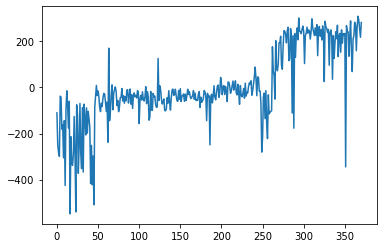

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 250:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))